In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns


In [7]:
# Define paths
train_dir = '/kaggle/input/guava-fruit-disease-dataset/Guava Fruit Disease Dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/train'
test_dir = '/kaggle/input/guava-fruit-disease-dataset/Guava Fruit Disease Dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/test'
val_dir = '/kaggle/input/guava-fruit-disease-dataset/Guava Fruit Disease Dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/val'


In [8]:
# Image dimensions
img_height = 224
img_width = 224
batch_size = 32

In [9]:
# Function to count images in each class
def count_images(directory):
    classes = ['Anthracnose', 'fruit_fly', 'healthy_guava']
    counts = {}
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        counts[class_name] = len(os.listdir(class_dir))
    return counts

# Count images in train, test, and validation sets
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)
val_counts = count_images(val_dir)

Training set counts: {'Anthracnose': 1080, 'fruit_fly': 918, 'healthy_guava': 649}
Validation set counts: {'Anthracnose': 308, 'fruit_fly': 262, 'healthy_guava': 185}
Test set counts: {'Anthracnose': 156, 'fruit_fly': 132, 'healthy_guava': 94}


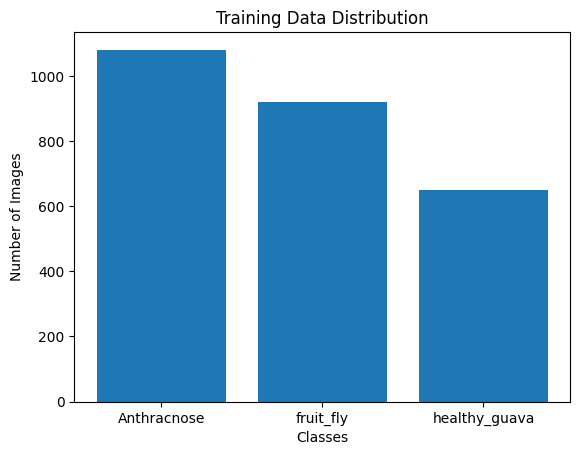

In [10]:
# Print the counts
print("Training set counts:", train_counts)
print("Validation set counts:", val_counts)
print("Test set counts:", test_counts)

# Plot bar chart for training set
plt.bar(train_counts.keys(), train_counts.values())
plt.title('Training Data Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()


In [11]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 2647 images belonging to 3 classes.
Found 755 images belonging to 3 classes.
Found 382 images belonging to 3 classes.


In [12]:
# Define a custom CNN block
def custom_cnn_block(x, filters):
    input_tensor = x
    x1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    x1 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x1)
    x2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    x2 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(x2)
    x = layers.Concatenate()([x1, x2])
    x = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    shortcut = layers.Conv2D(filters, (1, 1), padding='same')(input_tensor)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# Build the model using Functional API
inputs = layers.Input(shape=(img_height, img_width, 3))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = custom_cnn_block(x, 64)
x = custom_cnn_block(x, 128)
x = custom_cnn_block(x, 256)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(3, activation='softmax')(x)


In [13]:
model = models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Train the model
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733435018.996850     138 service.cc:145] XLA service 0x785638003c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733435018.996940     138 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-12-05 21:43:57.808631: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=4,k3=0} for conv (f32[32,256,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,112,112]{3,2,1,0}, f32[256,256,5,5]{3,2,1,0}, f32[256]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_targ

83/83 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.4532 - loss: 0.9974 - val_accuracy: 0.6238 - val_loss: 0.7172
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 446ms/step - accuracy: 0.7307 - loss: 0.6105 - val_accuracy: 0.6954 - val_loss: 0.6466
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 444ms/step - accuracy: 0.8001 - loss: 0.4942 - val_accuracy: 0.8675 - val_loss: 0.3269
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 446ms/step - accuracy: 0.8756 - loss: 0.3394 - val_accuracy: 0.9377 - val_loss: 0.1718
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 447ms/step - accuracy: 0.9230 - loss: 0.1956 - val_accuracy: 0.9656 - val_loss: 0.1116
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 447ms/step - accuracy: 0.9308 - loss: 0.1829 - val_accuracy: 0.9099 - val_loss: 0.2653
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 446ms/step - accuracy: 0.9411 - loss: 0.1870 - val_accuracy: 0.9483 - val_loss: 0.1582
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 448ms/step - accuracy: 0.9480 - loss: 0.1459 - val_accuracy: 0.9669 

In [15]:
# Feature extraction model
feature_extractor = models.Model(inputs=model.input, outputs=model.layers[-2].output)


In [16]:
# Extract features function
def extract_features(generator):
    features = []
    labels = []
    for inputs_batch, labels_batch in generator:
        features_batch = feature_extractor.predict(inputs_batch)
        features.append(features_batch)
        labels.append(labels_batch)
        if len(features) * generator.batch_size >= generator.samples:
            break
    features = np.vstack(features)
    labels = np.argmax(np.vstack(labels), axis=1)
    return features, labels

# Extract features
train_features, train_labels = extract_features(train_generator)
val_features, val_labels = extract_features(validation_generator)
test_features, test_labels = extract_features(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

2024-12-05 21:53:14.176759: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=4,k3=0} for conv (f32[30,256,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,256,112,112]{3,2,1,0}, f32[256,256,5,5]{3,2,1,0}, f32[256]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-05 21:53:14.221807: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.045159658s
Trying algorithm eng11{k2=4,k3=0} for conv (f32[30,256,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,256,112,112]{3,2,1,0}, f32[256,256,5,5]{3,2,1,0}, f32[256]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_confi

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


In [17]:
# Combine train and validation sets for ML classifiers
X = np.vstack([train_features, val_features])
y = np.hstack([train_labels, val_labels])


In [18]:
# Train-Test split for ML classifiers
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


In [22]:
# Initialize machine learning classifiers
classifiers = {
    'SVM': SVC(kernel='linear', probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': GaussianNB(),
}



Training SVM...
SVM Validation Accuracy: 0.9765
SVM Test Accuracy: 0.9817
SVM Classification Report:
               precision    recall  f1-score   support

  Anthracnose       1.00      0.99      1.00       156
    fruit_fly       0.96      0.99      0.97       132
healthy_guava       0.99      0.95      0.97        94

     accuracy                           0.98       382
    macro avg       0.98      0.98      0.98       382
 weighted avg       0.98      0.98      0.98       382



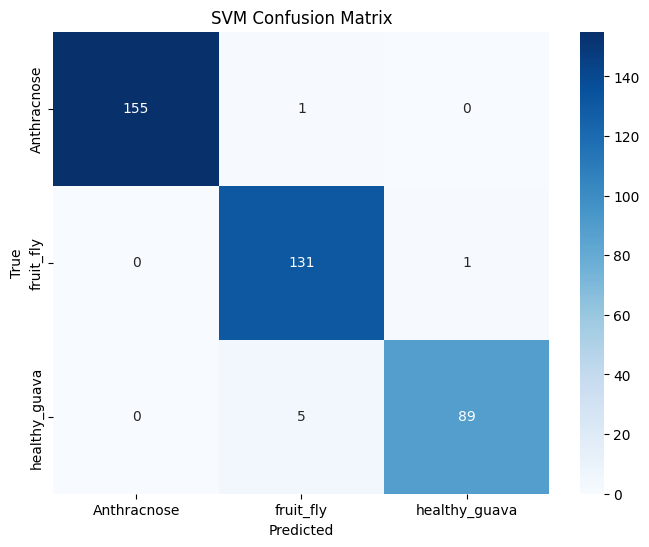


Training Decision Tree...
Decision Tree Validation Accuracy: 0.9721
Decision Tree Test Accuracy: 0.9843
Decision Tree Classification Report:
               precision    recall  f1-score   support

  Anthracnose       0.99      0.99      0.99       156
    fruit_fly       0.98      0.98      0.98       132
healthy_guava       0.98      0.98      0.98        94

     accuracy                           0.98       382
    macro avg       0.98      0.98      0.98       382
 weighted avg       0.98      0.98      0.98       382



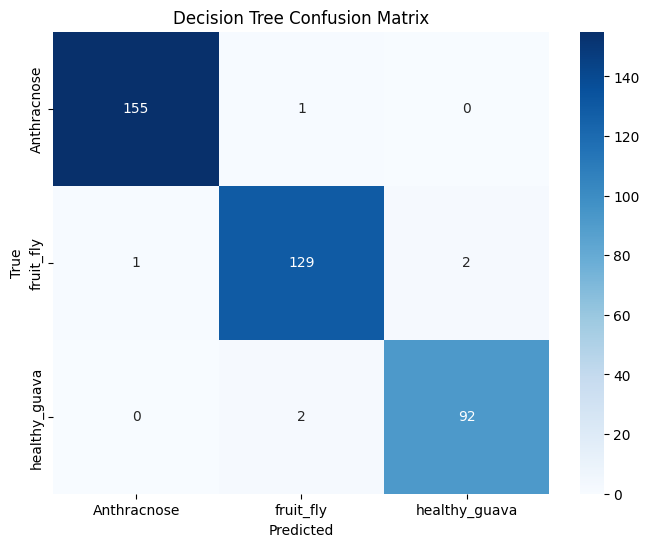


Training Random Forest...
Random Forest Validation Accuracy: 0.9838
Random Forest Test Accuracy: 0.9921
Random Forest Classification Report:
               precision    recall  f1-score   support

  Anthracnose       1.00      0.99      1.00       156
    fruit_fly       0.98      0.99      0.99       132
healthy_guava       0.99      0.99      0.99        94

     accuracy                           0.99       382
    macro avg       0.99      0.99      0.99       382
 weighted avg       0.99      0.99      0.99       382



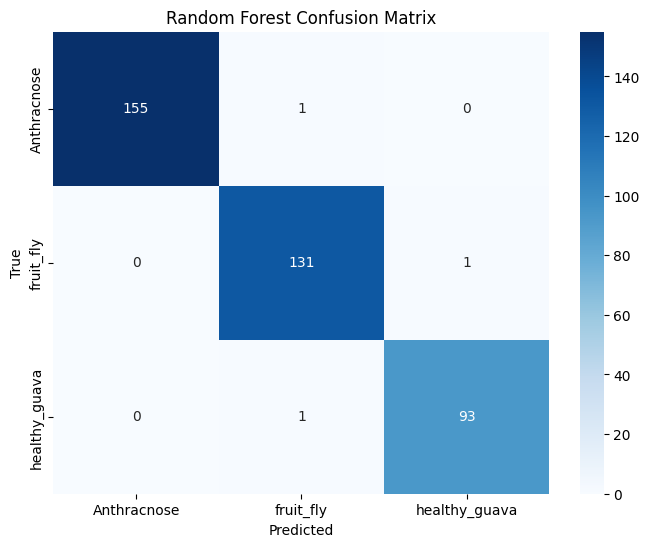


Training KNN...
KNN Validation Accuracy: 0.9809
KNN Test Accuracy: 0.9869
KNN Classification Report:
               precision    recall  f1-score   support

  Anthracnose       1.00      0.99      1.00       156
    fruit_fly       0.98      0.98      0.98       132
healthy_guava       0.98      0.98      0.98        94

     accuracy                           0.99       382
    macro avg       0.99      0.99      0.99       382
 weighted avg       0.99      0.99      0.99       382



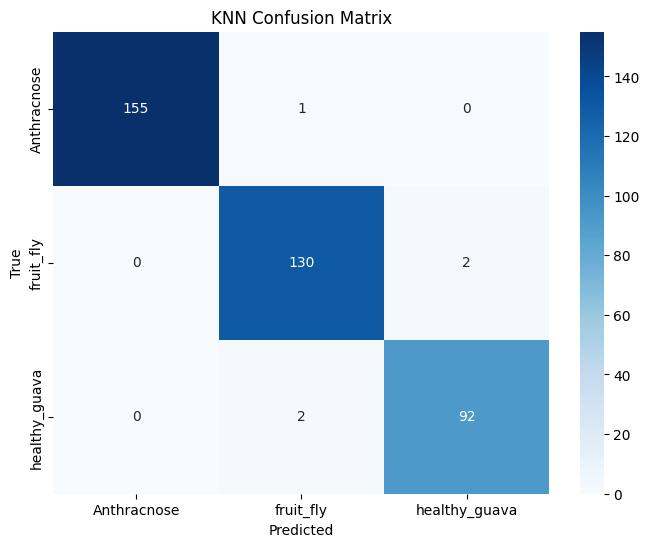


Training Gradient Boosting...
Gradient Boosting Validation Accuracy: 0.9868
Gradient Boosting Test Accuracy: 0.9869
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

  Anthracnose       0.99      0.99      0.99       156
    fruit_fly       0.98      0.98      0.98       132
healthy_guava       0.98      0.99      0.98        94

     accuracy                           0.99       382
    macro avg       0.99      0.99      0.99       382
 weighted avg       0.99      0.99      0.99       382



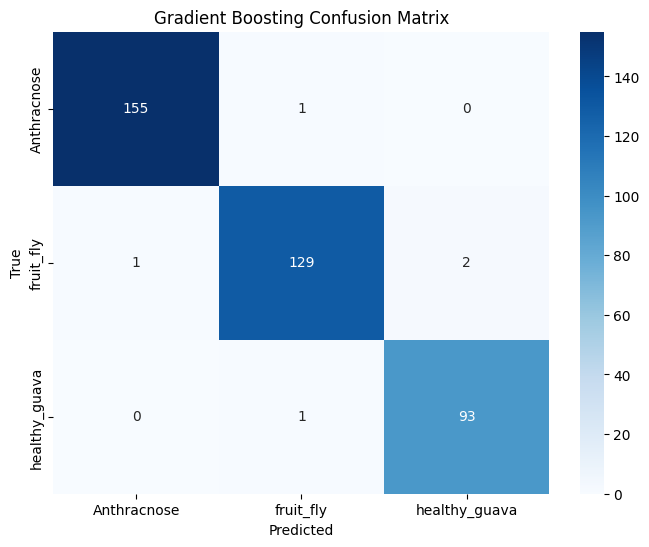


Training Extra Trees...
Extra Trees Validation Accuracy: 0.9794
Extra Trees Test Accuracy: 0.9895
Extra Trees Classification Report:
               precision    recall  f1-score   support

  Anthracnose       1.00      0.99      1.00       156
    fruit_fly       0.98      0.98      0.98       132
healthy_guava       0.98      0.99      0.98        94

     accuracy                           0.99       382
    macro avg       0.99      0.99      0.99       382
 weighted avg       0.99      0.99      0.99       382



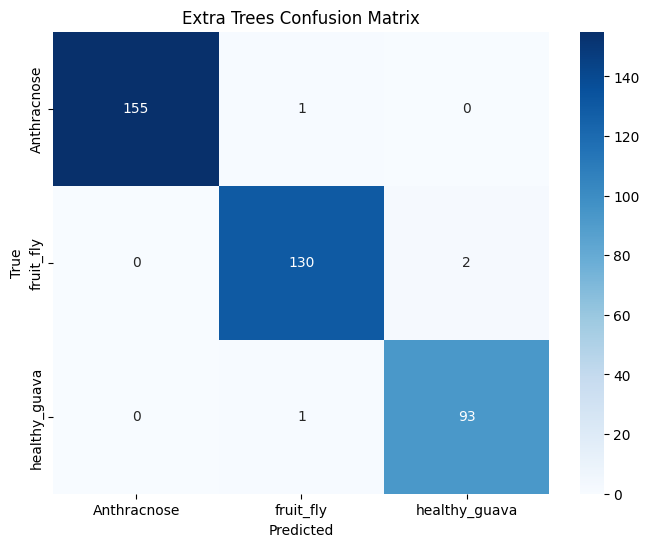


Training Logistic Regression...
Logistic Regression Validation Accuracy: 0.9809
Logistic Regression Test Accuracy: 0.9843
Logistic Regression Classification Report:
               precision    recall  f1-score   support

  Anthracnose       1.00      0.99      1.00       156
    fruit_fly       0.96      0.99      0.98       132
healthy_guava       0.99      0.96      0.97        94

     accuracy                           0.98       382
    macro avg       0.98      0.98      0.98       382
 weighted avg       0.98      0.98      0.98       382



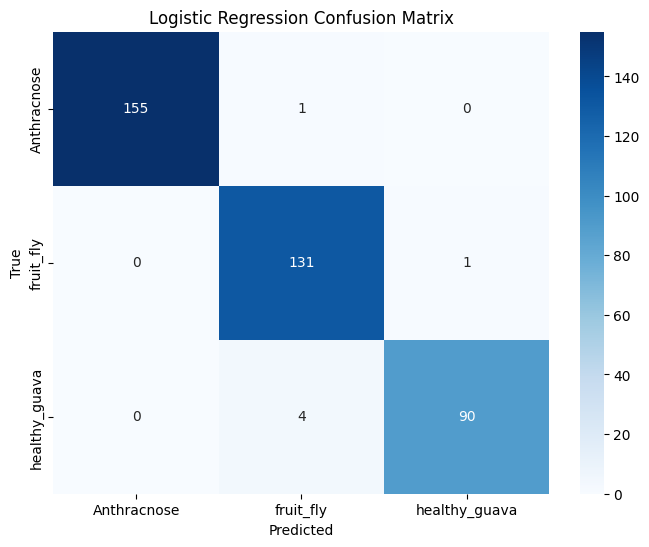


Training Naive Bayes...
Naive Bayes Validation Accuracy: 0.9677
Naive Bayes Test Accuracy: 0.9738
Naive Bayes Classification Report:
               precision    recall  f1-score   support

  Anthracnose       0.99      0.99      0.99       156
    fruit_fly       0.94      0.99      0.96       132
healthy_guava       1.00      0.93      0.96        94

     accuracy                           0.97       382
    macro avg       0.98      0.97      0.97       382
 weighted avg       0.98      0.97      0.97       382



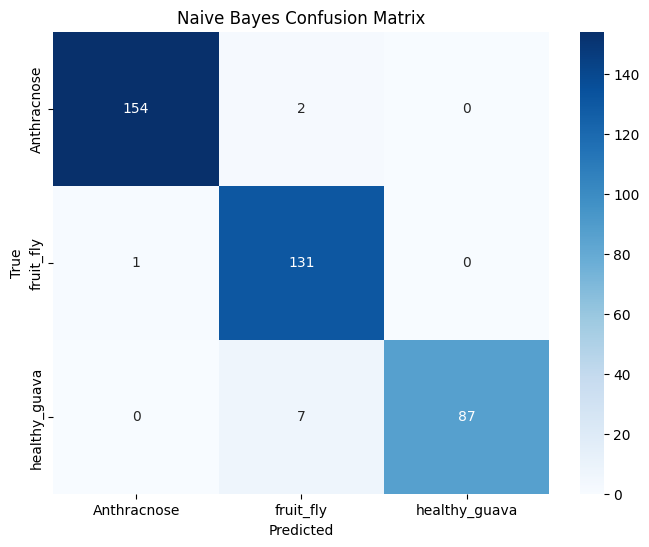

In [23]:
# Dictionary to store results
results = {}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)  # Train on extracted features

    # Validation predictions
    val_predictions = clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)

    # Test predictions
    test_predictions = clf.predict(test_features)
    test_accuracy = accuracy_score(test_labels, test_predictions)

    # Store results
    results[name] = {'Validation Accuracy': val_accuracy, 'Test Accuracy': test_accuracy}

    # Print accuracy
    print(f"{name} Validation Accuracy: {val_accuracy:.4f}")
    print(f"{name} Test Accuracy: {test_accuracy:.4f}")

    # Classification report and confusion matrix for test set
    print(f"{name} Classification Report:")
    print(classification_report(test_labels, test_predictions, target_names=test_generator.class_indices.keys()))

    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [24]:
# Display all results
print("\nSummary of Classifier Results:")
for name, metrics in results.items():
    print(f"{name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


Summary of Classifier Results:
SVM:
  Validation Accuracy: 0.9765
  Test Accuracy: 0.9817
Decision Tree:
  Validation Accuracy: 0.9721
  Test Accuracy: 0.9843
Random Forest:
  Validation Accuracy: 0.9838
  Test Accuracy: 0.9921
KNN:
  Validation Accuracy: 0.9809
  Test Accuracy: 0.9869
Gradient Boosting:
  Validation Accuracy: 0.9868
  Test Accuracy: 0.9869
Extra Trees:
  Validation Accuracy: 0.9794
  Test Accuracy: 0.9895
Logistic Regression:
  Validation Accuracy: 0.9809
  Test Accuracy: 0.9843
Naive Bayes:
  Validation Accuracy: 0.9677
  Test Accuracy: 0.9738
